# Core Imports and Setup

In [1]:
import os
from pathlib import Path

import numpy as np

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("openff.toolkit").setLevel(logging.ERROR)

from openff import toolkit, evaluator

from openff.units import unit

from matplotlib import pyplot

import matplotlib.pyplot as plt

from scipy.stats import linregress

# 0) Registering Custom ThermoML Properties

In [2]:
from openff.evaluator import properties
from openff.evaluator.datasets.thermoml import thermoml_property
from openff.evaluator.datasets import PhysicalProperty, PropertyPhase

@thermoml_property("Osmotic coefficient", supported_phases=PropertyPhase.Liquid)
class OsmoticCoefficient(PhysicalProperty):
    """A class representation of a osmotic coeff property"""

    @classmethod
    def default_unit(cls):
        return unit.dimensionless
    
...

custom_thermoml_props = [
    OsmoticCoefficient,
]

for custom_prop_cls in custom_thermoml_props:    
    setattr(properties, custom_prop_cls.__name__, custom_prop_cls)

# 1) - Loading ThermoML Data Sets

## Extracting data from ThermoML

In [3]:
from openff.evaluator.datasets import PhysicalProperty, PropertyPhase, PhysicalPropertyDataSet
from openff.evaluator.datasets.thermoml import thermoml_property, ThermoMLDataSet

data_set_initial = PhysicalPropertyDataSet.from_json("training-properties-with-water.json")
data_set_initial.to_pandas()

,Id,Temperature (K),Pressure (kPa),Phase,N Components,Component 1,Role 1,Mole Fraction 1,Exact Amount 1,Component 2,Role 2,Mole Fraction 2,Exact Amount 2,EnthalpyOfMixing Value (kJ / mol),EnthalpyOfMixing Uncertainty (kJ / mol),Density Value (g / ml),Density Uncertainty (g / ml),Source
0,6385,298.15,101.0,Liquid,2,CN1CCCCC1,Solvent,0.24520,None,O,Solvent,0.75480,None,NaN,NaN,0.903811,NaN,10.1016/j.fluid.2010.05.001
1,6386,298.15,101.0,Liquid,2,CN1CCCCC1,Solvent,0.50500,None,O,Solvent,0.49500,None,NaN,NaN,0.858158,NaN,10.1016/j.fluid.2010.05.001
2,6387,298.15,101.0,Liquid,2,CN1CCCCC1,Solvent,0.79070,None,O,Solvent,0.20930,None,NaN,NaN,0.826047,NaN,10.1016/j.fluid.2010.05.001
3,6388,298.15,101.3,Liquid,2,CN(C)CCO,Solvent,0.26433,None,O,Solvent,0.73567,None,NaN,NaN,0.959000,NaN,10.1021/acs.jced.6b00888
4,6389,298.15,101.3,Liquid,2,CN(C)CCO,Solvent,0.50770,None,O,Solvent,0.49230,None,NaN,NaN,0.923722,NaN,10.1016/j.jct.2004.11.016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,7294,298.15,101.0,Liquid,2,C1COCCN1,Solvent,0.49110,None,O,Solvent,0.50890,None,-3.131,NaN,NaN,NaN,10.1016/j.jct.2015.06.006
119,7295,298.15,101.0,Liquid,2,C1COCCN1,Solvent,0.71490,None,O,Solvent,0.28510,None,-1.753,NaN,NaN,NaN,10.1016/j.jct.2015.06.006
120,7344,303.15,100.0,Liquid,2,NCCCNCCCN,Solvent,0.30050,None,O,Solvent,0.69950,None,-6.588,NaN,NaN,NaN,10.1016/j.jct.2015.04.030
121,7345,303.15,100.0,Liquid,2,NCCCNCCCN,Solvent,0.49980,None,O,Solvent,0.50020,None,-5.544,NaN,NaN,NaN,10.1016/j.jct.2015.04.030


In [4]:
print(len(data_set_initial))
print(data_set_initial.property_types)
print(data_set_initial.substances)

123
{'EnthalpyOfMixing', 'Density'}
{<Substance NCCCO{solv}{x=0.298200}|O{solv}{x=0.701800}>, <Substance OCCOCCO{solv}{x=0.301000}|O{solv}{x=0.699000}>, <Substance CN(C)CCO{solv}{x=0.765200}|O{solv}{x=0.234800}>, <Substance OCCOCCO{solv}{x=0.790600}|O{solv}{x=0.209400}>, <Substance CN1CCOCC1{solv}{x=0.498300}|O{solv}{x=0.501700}>, <Substance CC(C)O{solv}{x=0.203100}|O{solv}{x=0.796900}>, <Substance OC1=NCCC1{solv}{x=0.744800}|O{solv}{x=0.255200}>, <Substance NCCNCCN{solv}{x=0.501000}|O{solv}{x=0.499000}>, <Substance C1COCCN1{solv}{x=0.201000}|O{solv}{x=0.799000}>, <Substance C1COCCN1{solv}{x=0.491100}|O{solv}{x=0.508900}>, <Substance CN(CCO)CCO{solv}{x=0.741100}|O{solv}{x=0.258900}>, <Substance OCCNCCO{solv}{x=0.294300}|O{solv}{x=0.705700}>, <Substance CNCCO{solv}{x=0.800900}|O{solv}{x=0.199100}>, <Substance C1CCNCC1{solv}{x=0.250000}|O{solv}{x=0.750000}>, <Substance CN1CCNCC1{solv}{x=0.209100}|O{solv}{x=0.790900}>, <Substance CCN(CC)CCO{solv}{x=0.700300}|O{solv}{x=0.299700}>, <Substan

## Filtering data set

In [5]:
from openff.evaluator.datasets.curation.components.filtering import FilterByPropertyTypes, FilterByPropertyTypesSchema
from openff.evaluator.datasets.curation.components.filtering import FilterByTemperature, FilterByTemperatureSchema
from openff.evaluator.datasets.curation.components.filtering import FilterByPressure, FilterByPressureSchema
from openff.evaluator.datasets.curation.components.filtering import FilterBySmiles, FilterBySmilesSchema

data_set_hmix_dens= FilterByPropertyTypes.apply(
    data_set_initial, FilterByPropertyTypesSchema(property_types=["EnthalpyOfMixing","Density"]))

print(len(data_set_hmix_dens))

123


### Inspecting and saving new properties

In [6]:
# save for future use
data_set_path = Path('filtered_dataset_hmix_dens.json')
data_set_hmix_dens.json(data_set_path, format=True)

# inspect new properties
pandas_data_set = data_set_hmix_dens.to_pandas()

## 3) Analysing Data Sets

### Plotting results separately

In [7]:
def analysis_waters():

    water_models=('TIP3P','TIP3P_FB')

    for w in water_models:

        experimental_data_set_path = 'filtered_dataset_hmix_dens.json'
        estimated_data_set_path = '%s/estimated_dataset_hmix_dens.json' %w

        experimental_data_set = PhysicalPropertyDataSet.from_json(experimental_data_set_path)
        estimated_data_set = PhysicalPropertyDataSet.from_json(estimated_data_set_path)

        properties_by_type = {"Density": [], "EnthalpyOfMixing": []}

        for experimental_property in experimental_data_set:
            # Find the estimated property which has the same id as the
            # experimental property.
            estimated_property = next(
                x for x in estimated_data_set if x.id == experimental_property.id
            )

            # Add this pair of properties to the list of pairs
            property_type = experimental_property.__class__.__name__
            properties_by_type[property_type].append(
                (experimental_property, estimated_property)
            )
        
        # Create the figure we will plot to.
        figure, axes = pyplot.subplots(nrows=1, ncols=2, figsize=(10.0, 5.0))

        # Set the axis titles
        axes[0].set_xlabel("OpenFF 2.1.0")
        axes[0].set_ylabel("Experimental")
        axes[0].set_title("Density $kg m^{-3}$ - %s" %w)

        axes[1].set_xlabel("OpenFF 2.1.0")
        axes[1].set_ylabel("Experimental")
        axes[1].set_title("$H_{mix}$ $kJ mol^{-1}$ - %s" %w)

        # Define the preferred units of the properties
        from openff.units import unit

        preferred_units = {
            "Density": unit.kilogram / unit.meter**3,
            "EnthalpyOfMixing": unit.kilojoule / unit.mole,
        }

        for index, property_type in enumerate(properties_by_type):
            experimental_values = []
            estimated_values = []

            preferred_unit = preferred_units[property_type]

            # Convert the values of our properties to the preferred units.
            for experimental_property, estimated_property in properties_by_type[property_type]:
                experimental_values.append(
                    experimental_property.value.to(preferred_unit).magnitude
                )
                estimated_values.append(estimated_property.value.to(preferred_unit).magnitude)

            axes[index].plot(
                estimated_values, experimental_values, marker="x", linestyle="None"
            )
        

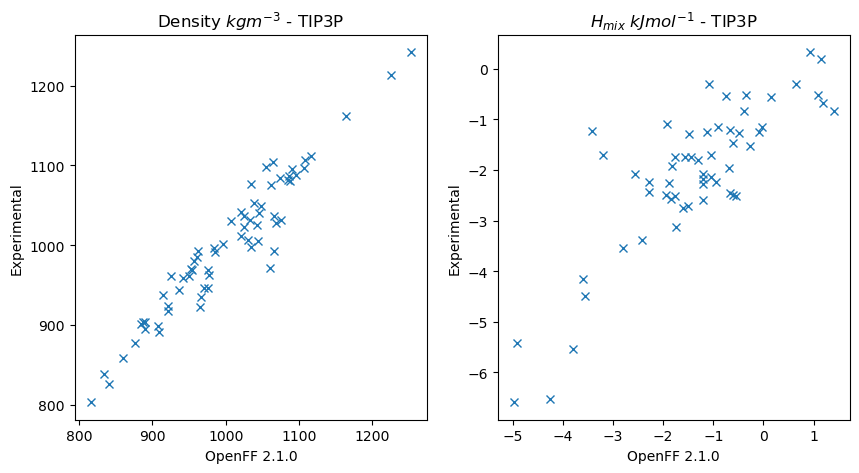

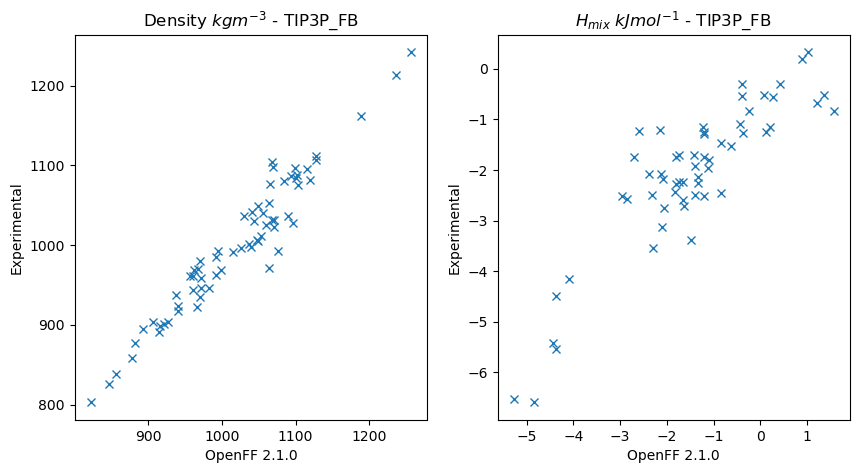

In [8]:
analysis_waters()

### Plotting results all together

In [9]:
def analysis_all(phys_prop,water_model):
    
    experimental_data_set_path = 'filtered_dataset_hmix_dens.json'
    estimated_data_set_path = ('%s/estimated_dataset_hmix_dens.json'%water_model)

    experimental_data_set = PhysicalPropertyDataSet.from_json(experimental_data_set_path)
    estimated_data_set = PhysicalPropertyDataSet.from_json(estimated_data_set_path)

    properties_by_type = {phys_prop: []}

    for experimental_property in experimental_data_set:

        if (type(experimental_property).__qualname__) == phys_prop:
    #     # Find the estimated property which has the same id as the
    #     # experimental property.
            property_type = experimental_property.__class__.__name__
            estimated_property = next(
                x for x in estimated_data_set if x.id == experimental_property.id
            )
            # Add this pair of properties to the list of pairs
            properties_by_type[property_type].append((experimental_property, estimated_property))
    
    preferred_units = {
        "Density": unit.kilogram / unit.meter**3,
        "EnthalpyOfMixing": unit.kilojoule / unit.mole,
    }

    experimental_values = []
    estimated_values = []
    preferred_unit = preferred_units[property_type]
    
    for experimental_property, estimated_property in properties_by_type[property_type]:
        experimental_values.append(
            experimental_property.value.to(preferred_unit).magnitude
        )
        estimated_values.append(
            estimated_property.value.to(preferred_unit).magnitude
        )

    def results_stats(x,y):    
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        r2_value=r_value**2
        
        xarr=np.array(x)
        yarr=np.array(y)
        mse= ((xarr - yarr) ** 2).mean()
        rmse=np.sqrt(mse)

        stats=dict()
        stats['slope']=slope
        stats['intercept']=intercept
        stats['r_value']=r_value
        stats['r2_value']=r2_value
        stats['p_value']=p_value
        stats['std_err']=std_err
        stats['rmse']=rmse
        return stats

    results=dict()
    results["%s:%s-Experimental_Values" %(water_model,phys_prop)]=experimental_values
    results["%s:%s-Estimated_Values" %(water_model,phys_prop)]=estimated_values
    results["%s:%s-Stats" %(water_model,phys_prop)]=results_stats(estimated_values,experimental_values)
    
    return results

In [11]:
waters=('TIP3P','TIP3P_FB','TIP4P','TIP4P_FB','OPC','OPC3','GOPAL')

results=dict()

for w in waters:
    dens_result=analysis_all('Density', w)
    results.update(dens_result)
    hmix_result=analysis_all('EnthalpyOfMixing',w)
    results.update(hmix_result)

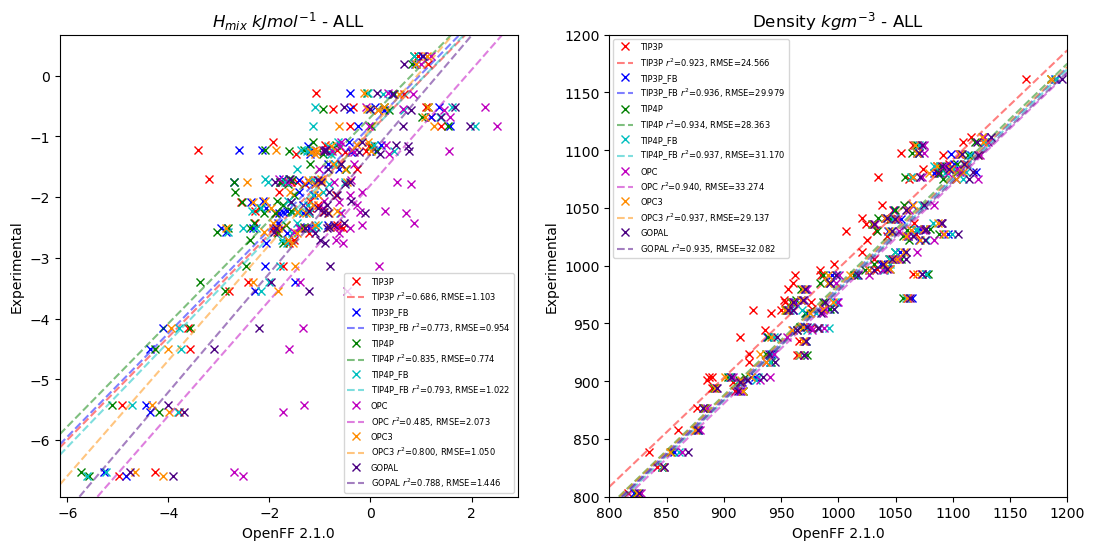

In [15]:
plt.figure(figsize=(13.0, 6.0))
plt.subplot(1,2,1)
plt.plot(results['TIP3P:EnthalpyOfMixing-Estimated_Values'], results['TIP3P:EnthalpyOfMixing-Experimental_Values'], marker='x', linestyle='None', color='r', label='TIP3P')
plt.axline(xy1=(0,results['TIP3P:EnthalpyOfMixing-Stats']['intercept']),slope=results['TIP3P:EnthalpyOfMixing-Stats']['slope'], linestyle="--", color='r', alpha=0.5, label='TIP3P $r^{2}$=%.3f, RMSE=%.3f'%(results['TIP3P:EnthalpyOfMixing-Stats']['r2_value'],results['TIP3P:EnthalpyOfMixing-Stats']['rmse']))
plt.plot(results['TIP3P_FB:EnthalpyOfMixing-Estimated_Values'], results['TIP3P_FB:EnthalpyOfMixing-Experimental_Values'], marker='x', linestyle='None', color='b',label='TIP3P_FB')
plt.axline(xy1=(0,results['TIP3P_FB:EnthalpyOfMixing-Stats']['intercept']),slope=results['TIP3P_FB:EnthalpyOfMixing-Stats']['slope'], linestyle="--", color='b', alpha=0.5, label='TIP3P_FB $r^{2}$=%.3f, RMSE=%.3f'%(results['TIP3P_FB:EnthalpyOfMixing-Stats']['r2_value'], results['TIP3P_FB:EnthalpyOfMixing-Stats']['rmse']))
plt.plot(results['TIP4P:EnthalpyOfMixing-Estimated_Values'], results['TIP4P:EnthalpyOfMixing-Experimental_Values'], marker='x', linestyle='None', color='g', label='TIP4P')
plt.axline(xy1=(0,results['TIP4P:EnthalpyOfMixing-Stats']['intercept']),slope=results['TIP4P:EnthalpyOfMixing-Stats']['slope'], linestyle="--", color='g', alpha=0.5, label='TIP4P $r^{2}$=%.3f, RMSE=%.3f'%(results['TIP4P:EnthalpyOfMixing-Stats']['r2_value'],results['TIP4P:EnthalpyOfMixing-Stats']['rmse']))
plt.plot(results['TIP4P_FB:EnthalpyOfMixing-Estimated_Values'], results['TIP4P_FB:EnthalpyOfMixing-Experimental_Values'], marker='x', linestyle='None', color='c',label='TIP4P_FB')
plt.axline(xy1=(0,results['TIP4P_FB:EnthalpyOfMixing-Stats']['intercept']),slope=results['TIP4P_FB:EnthalpyOfMixing-Stats']['slope'], linestyle="--", color='c', alpha=0.5, label='TIP4P_FB $r^{2}$=%.3f, RMSE=%.3f'%(results['TIP4P_FB:EnthalpyOfMixing-Stats']['r2_value'],results['TIP4P_FB:EnthalpyOfMixing-Stats']['rmse']))
plt.plot(results['OPC:EnthalpyOfMixing-Estimated_Values'], results['OPC:EnthalpyOfMixing-Experimental_Values'], marker='x', linestyle='None', color='m', label='OPC')
plt.axline(xy1=(0,results['OPC:EnthalpyOfMixing-Stats']['intercept']),slope=results['OPC:EnthalpyOfMixing-Stats']['slope'], linestyle="--", color='m', alpha=0.5, label='OPC $r^{2}$=%.3f, RMSE=%.3f'%(results['OPC:EnthalpyOfMixing-Stats']['r2_value'],results['OPC:EnthalpyOfMixing-Stats']['rmse']))
plt.plot(results['OPC3:EnthalpyOfMixing-Estimated_Values'], results['OPC3:EnthalpyOfMixing-Experimental_Values'], marker='x', linestyle='None', color='darkorange', label='OPC3')
plt.axline(xy1=(0,results['OPC3:EnthalpyOfMixing-Stats']['intercept']),slope=results['OPC3:EnthalpyOfMixing-Stats']['slope'], linestyle="--", color='darkorange', alpha=0.5, label='OPC3 $r^{2}$=%.3f, RMSE=%.3f'%(results['OPC3:EnthalpyOfMixing-Stats']['r2_value'],results['OPC3:EnthalpyOfMixing-Stats']['rmse']))
plt.plot(results['GOPAL:EnthalpyOfMixing-Estimated_Values'], results['GOPAL:EnthalpyOfMixing-Experimental_Values'], marker='x', linestyle='None', color='indigo', label='GOPAL')
plt.axline(xy1=(0,results['GOPAL:EnthalpyOfMixing-Stats']['intercept']),slope=results['GOPAL:EnthalpyOfMixing-Stats']['slope'], linestyle="--", color='indigo', alpha=0.5, label='GOPAL $r^{2}$=%.3f, RMSE=%.3f'%(results['GOPAL:EnthalpyOfMixing-Stats']['r2_value'],results['GOPAL:EnthalpyOfMixing-Stats']['rmse']))
plt.title('$H_{mix}$ $kJ mol^{-1}$ - ALL')
plt.xlabel('OpenFF 2.1.0')
plt.ylabel('Experimental')
plt.legend(prop={'size': 6})

plt.subplot(1,2,2)
plt.plot(results['TIP3P:Density-Estimated_Values'], results['TIP3P:Density-Experimental_Values'], marker='x', linestyle='None', color='r', label='TIP3P')
plt.axline(xy1=(0,results['TIP3P:Density-Stats']['intercept']),slope=results['TIP3P:Density-Stats']['slope'], linestyle="--", color='r', alpha=0.5, label='TIP3P $r^{2}$=%.3f, RMSE=%.3f'%(results['TIP3P:Density-Stats']['r2_value'], results['TIP3P:Density-Stats']['rmse']))
plt.plot(results['TIP3P_FB:Density-Estimated_Values'], results['TIP3P_FB:Density-Experimental_Values'], marker='x', linestyle='None', color='b',label='TIP3P_FB')
plt.axline(xy1=(0,results['TIP3P_FB:Density-Stats']['intercept']),slope=results['TIP3P_FB:Density-Stats']['slope'], linestyle="--", color='b', alpha=0.5, label='TIP3P_FB $r^{2}$=%.3f, RMSE=%.3f'%(results['TIP3P_FB:Density-Stats']['r2_value'], results['TIP3P_FB:Density-Stats']['rmse']))
plt.plot(results['TIP4P:Density-Estimated_Values'], results['TIP4P:Density-Experimental_Values'], marker='x', linestyle='None', color='g', label='TIP4P')
plt.axline(xy1=(0,results['TIP4P:Density-Stats']['intercept']),slope=results['TIP4P:Density-Stats']['slope'], linestyle="--", color='g', alpha=0.5, label='TIP4P $r^{2}$=%.3f, RMSE=%.3f'%(results['TIP4P:Density-Stats']['r2_value'], results['TIP4P:Density-Stats']['rmse']))
plt.plot(results['TIP4P_FB:Density-Estimated_Values'], results['TIP4P_FB:Density-Experimental_Values'], marker='x', linestyle='None', color='c',label='TIP4P_FB')
plt.axline(xy1=(0,results['TIP4P_FB:Density-Stats']['intercept']),slope=results['TIP4P_FB:Density-Stats']['slope'], linestyle="--", color='c', alpha=0.5, label='TIP4P_FB $r^{2}$=%.3f, RMSE=%.3f'%(results['TIP4P_FB:Density-Stats']['r2_value'], results['TIP4P_FB:Density-Stats']['rmse']))
plt.plot(results['OPC:Density-Estimated_Values'], results['OPC:Density-Experimental_Values'], marker='x', linestyle='None', color='m',label='OPC')
plt.axline(xy1=(0,results['OPC:Density-Stats']['intercept']),slope=results['OPC:Density-Stats']['slope'], linestyle="--", color='m', alpha=0.5, label='OPC $r^{2}$=%.3f, RMSE=%.3f'%(results['OPC:Density-Stats']['r2_value'], results['OPC:Density-Stats']['rmse']))
plt.plot(results['OPC3:Density-Estimated_Values'], results['OPC3:Density-Experimental_Values'], marker='x', linestyle='None', color='darkorange',label='OPC3')
plt.axline(xy1=(0,results['OPC3:Density-Stats']['intercept']),slope=results['OPC3:Density-Stats']['slope'], linestyle="--", color='darkorange', alpha=0.5, label='OPC3 $r^{2}$=%.3f, RMSE=%.3f'%(results['OPC3:Density-Stats']['r2_value'], results['OPC3:Density-Stats']['rmse']))
plt.plot(results['GOPAL:Density-Estimated_Values'], results['GOPAL:Density-Experimental_Values'], marker='x', linestyle='None', color='indigo',label='GOPAL')
plt.axline(xy1=(0,results['GOPAL:Density-Stats']['intercept']),slope=results['GOPAL:Density-Stats']['slope'], linestyle="--", color='indigo', alpha=0.5, label='GOPAL $r^{2}$=%.3f, RMSE=%.3f'%(results['GOPAL:Density-Stats']['r2_value'], results['GOPAL:Density-Stats']['rmse']))
plt.xlim(800,1200)
plt.ylim(800,1200)
plt.title('Density $kg m^{-3}$ - ALL') 
plt.xlabel('OpenFF 2.1.0')
plt.ylabel('Experimental')
plt.legend(prop={'size': 6})

plt.savefig('hmix_dens_plot.png')

plt.show()

In [35]:
from sklearn.metrics import r2_score, mean_squared_error

# Function to calculate R^2 and RMSE stats
def stats(experimental_values, estimated_values):
    r2 = r2_score(experimental_values, estimated_values)
    rmse = np.sqrt(mean_squared_error(experimental_values, estimated_values))
    return r2, rmse

# Bootstrap function
def bootstrap_mols(experimental_values, estimated_values, n_bootstraps=1000):
    r2_list = []
    rmse_list = []

    n_samples = len(experimental_values)
    for _ in range(n_bootstraps):
        ## Sampling molecule indices with replacement
        sample_indices = np.random.choice(n_samples, n_samples, replace=True)
        sample_true = np.array(experimental_values)[sample_indices]
        sample_pred = np.array(estimated_values)[sample_indices]
        
        ## Calculate R^2 and RMSE from taken sample
        r2, rmse = stats(sample_true, sample_pred)
        r2_list.append(r2)
        rmse_list.append(rmse)
    
    # Calculating error bounds
    r2_bounds = (np.percentile(r2_list, 2.5), np.percentile(r2_list, 97.5))
    rmse_bounds = (np.percentile(rmse_list, 2.5), np.percentile(rmse_list, 97.5))
    
    return r2_bounds, rmse_bounds



In [38]:
experimental_values = results['TIP3P:EnthalpyOfMixing-Experimental_Values']
estimated_values = results['TIP3P:EnthalpyOfMixing-Estimated_Values']

n_bootstraps = 1000

r2_bounds, rmse_bounds = bootstrap_mols(experimental_values, estimated_values, n_bootstraps)

print(f"R^2 bounds: {r2_bounds}")
print(f"RMSE bounds: {rmse_bounds}")

R^2 bounds: (-0.05096021668337665, 0.6227424038577425)
RMSE bounds: (0.9437118423411137, 1.2484598780099618)


In [37]:
if __name__ == "__main__":

    experimental_values = results['TIP3P_FB:EnthalpyOfMixing-Experimental_Values']
    estimated_values = results['TIP3P_FB:EnthalpyOfMixing-Estimated_Values']

    n_bootstraps = 1000

    r2_bounds, rmse_bounds = bootstrap_mols(experimental_values, estimated_values, n_bootstraps)

    print(f"R^2 bounds: {r2_bounds}")
    print(f"RMSE bounds: {rmse_bounds}")

R^2 bounds: (0.13302637901576253, 0.7305877081176794)
RMSE bounds: (0.7981626716173322, 1.105540954934584)
